In [29]:
from nansat import Nansat
from osgeo import gdal
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import scipy
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
s2_path = '/container_dir1/Subset_S2_20210716_resampled.tif'
# rpoints = 'C:/Users/ariane/shared/NERSC/classification/rasterpoints.shp'
path = '/container_dir1/'

Variable                 Type             Data/Info
---------------------------------------------------
ConfusionMatrixDisplay   type             <class 'sklearn.metrics._<...>.ConfusionMatrixDisplay'>
Domain                   type             <class 'nansat.domain.Domain'>
Figure                   type             <class 'nansat.figure.Figure'>
LogisticRegression       type             <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
NSR                      type             <class 'nansat.nsr.NSR'>
Nansat                   type             <class 'nansat.nansat.Nansat'>
PCA                      ABCMeta          <class 'sklearn.decomposition._pca.PCA'>
RandomForestClassifier   ABCMeta          <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
StandardScaler           type             <class 'sklearn.preproces<...>ng._data.StandardScaler'>
accuracy_score           function         <function accuracy_score at 0x7f694e4a20e0>
arr                      ndarray          6x1091x

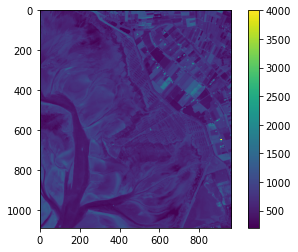

In [31]:
# Trying nansat functions - open and plot file with satellite data

# n = Nansat(s2_path)
with rasterio.open(s2_path) as s2: 
    meta = s2.meta
    arr = s2.read()
n = arr
b2 = n[1]

%whos
plt.imshow(b2, vmin=200, vmax=4000);plt.colorbar()
plt.show()

# n.write_figure('map.png', pltshow=True)

In [32]:
meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 960,
 'height': 1091,
 'count': 6,
 'crs': CRS.from_epsg(32632),
 'transform': Affine(10.0, 0.0, 484550.0,
        0.0, -10.0, 6057160.0)}

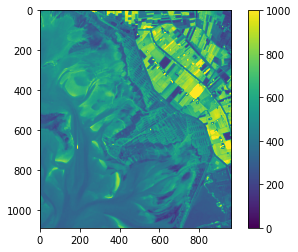

In [39]:
### open file with satellite data; define domain for the region of interest
from nansat import *

# n = Nansat(path+ r'Subset_S2_20210716_resampled.tif')
# this syntax doesn´t work

n = gdal.Open(s2_path)
d = Domain(ds = n)
# d = Domain('+proj=longlat', '-te 27 70.3 31 71.6 -tr 0.015 0.005')
# d = Domain('+proj=stere +lat_0=58 +lon_0=5 +no_defs',
#           '-te -300000 -300000 300000 300000 -tr 3000 3000')


sep = '/container_dir1/Subset_S2A_20210909_resampled.tif'
sep = Nansat(sep)
b2 = sep[1]
plt.imshow(b2, vmin=0, vmax=1000);plt.colorbar()
plt.show()

In [47]:
Domain?


Init signature: Domain(srs=None, ext=None, ds=None, **kwargs)
Docstring:     
Container for geographical reference of a raster

A Domain object describes all attributes of geographical
reference of a raster:

  * width and height (number of pixels)
  * pixel size (e.g. in decimal degrees or in meters)
  * relation between pixel/line coordinates and geographical
    coordinates (e.g. a linear relation)
  * type of data projection (e.g. geographical or stereographic)

Parameters
----------
srs : PROJ4 or EPSG or WKT or NSR or osr.SpatialReference()
    Input parameter for nansat.NSR()
ext : string
    some gdalwarp options + additional options
    [http://www.gdal.org/gdalwarp.html]
    Specifies extent, resolution / size
    Available options: (('-te' or '-lle') and ('-tr' or '-ts'))
    (e.g. '-lle -10 30 55 60 -ts 1000 1000' or
    '-te 100 2000 300 10000 -tr 300 200')
    -tr resolutionx resolutiony
    -ts sizex sizey
    -te xmin ymin xmax ymax
    -lle lonmin latmin lonmax latmax


In [40]:
sep

----------------------------------------
/container_dir1/Subset_S2A_20210909_resampled.tif----------------------------------------
Mapper: genericBand : 1 band_000
  dataType: 2
  name: band_000
  SourceBand: 1
  SourceFilename: /container_dir1/Subset_S2A_20210909_resampled.tif
  wkv: 
Band : 2 band_001
  dataType: 2
  name: band_001
  SourceBand: 2
  SourceFilename: /container_dir1/Subset_S2A_20210909_resampled.tif
  wkv: 
Band : 3 band_002
  dataType: 2
  name: band_002
  SourceBand: 3
  SourceFilename: /container_dir1/Subset_S2A_20210909_resampled.tif
  wkv: 
Band : 4 band_003
  dataType: 2
  name: band_003
  SourceBand: 4
  SourceFilename: /container_dir1/Subset_S2A_20210909_resampled.tif
  wkv: 
Band : 5 band_004
  dataType: 2
  name: band_004
  SourceBand: 5
  SourceFilename: /container_dir1/Subset_S2A_20210909_resampled.tif
  wkv: 
Band : 6 band_005
  dataType: 2
  name: band_005
  SourceBand: 6
  SourceFilename: /container_dir1/Subset_S2A_20210909_resampled.tif
  wkv: 
--------

In [38]:
### Reproject data 
# n.reproject(d, 2)
sep.reproject(d,2)
# Reprojection always produces error: "AttributeError: 'NoneType' object has no attribute 'reproject'"

AttributeError: 'NoneType' object has no attribute 'reproject'

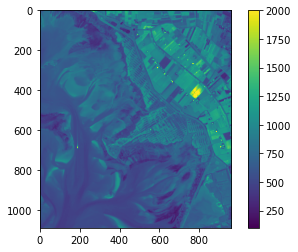

In [44]:
plt.imshow(sep[2], clim=(100, 2000))
plt.colorbar()
plt.show()

In [45]:
wm = sep.watermask()[1]

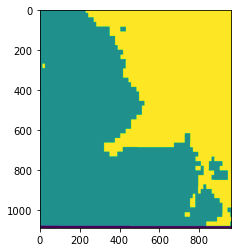

In [46]:
plt.imshow(wm)


In [48]:
from rasterio.mask import mask

lm = gpd.read_file('/container_dir1/land_mask_HH.shp')



In [49]:
lm

,id,geometry
0,1,"POLYGON ((8.81291 54.66162, 8.90945 54.66180, ..."


In [52]:
with rasterio.open(path+'/subsets/Subset_S2A_20210909_resampled.tif') as s2: 
    meta = s2.meta
    arr = s2.read()
    
out, _ = mask(arr, lm.geometry, invert=False)

AttributeError: 'numpy.ndarray' object has no attribute 'nodata'